In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import seaborn as sn
import numpy as np
import joblib    
import pickle
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
IMAGE_SIZE=256
BATCH_SIZE=16
CHANNELS=3
EPOCHS=20

In [3]:
dataset=tf.keras.preprocessing.image_dataset_from_directory(
    "D:\Ishita\IGDTUW (CSE)\Summer Internship 2023\PlantVillage",
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [4]:
class_names=dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [5]:
len(dataset)

135

(16, 256, 256, 3)
[1 1 0 0 1 1 1 1 0 0 0 2 0 0 1 0]


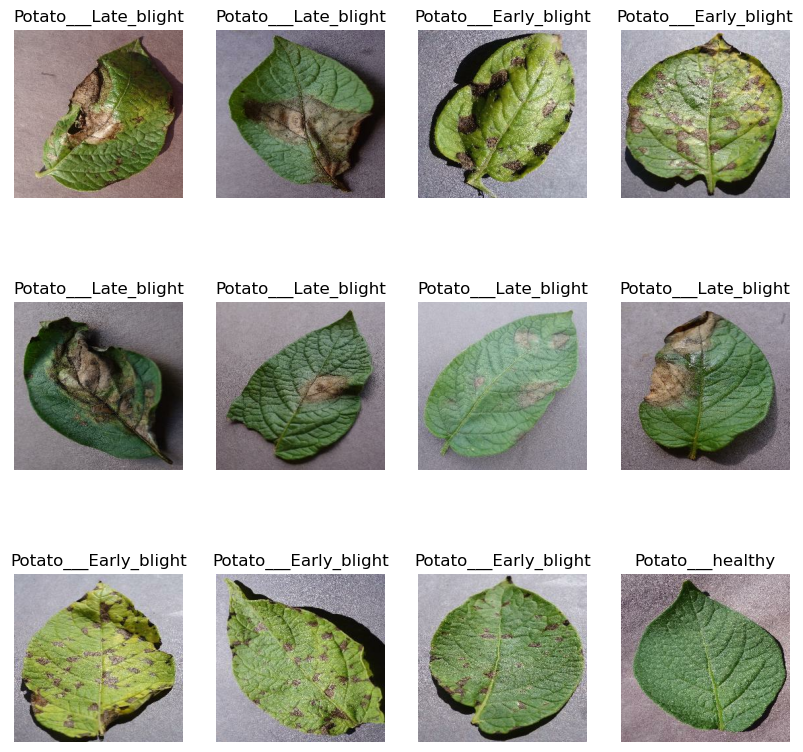

In [6]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())
    for i in range(12):
        ax=plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [7]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    ds_size=len(ds)
    if shuffle:
        ds=ds.shuffle(shuffle_size, seed=12)
    train_size=int(train_split*ds_size)
    val_size=int(val_split*ds_size)
    train_ds=ds.take(train_size)
    val_ds=ds.skip(train_size).take(val_size)
    test_ds=ds.skip(train_size).skip(val_size)
    return train_ds, val_ds, test_ds
train_ds, val_ds, test_ds=get_dataset_partitions_tf(dataset)

In [8]:
print(len(train_ds), len(val_ds), len(test_ds))

108 13 14


In [9]:
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds=val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds=test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [10]:
resize_and_rescale=tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])
data_augmentation=tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

In [11]:
input_shape=(BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes=3
model=models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax')
])
model.build(input_shape=input_shape)
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (16, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (16, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (16, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (16, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (16, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (16, 62, 62, 64)         0         
 2D)                                                  

In [12]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)
history=model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/20
108/108 [==============================] - 86s 775ms/step - loss: 0.8950 - accuracy: 0.5133 - val_loss: 0.6407 - val_accuracy: 0.7800
Epoch 2/20
108/108 [==============================] - 73s 674ms/step - loss: 0.6264 - accuracy: 0.7465 - val_loss: 0.4133 - val_accuracy: 0.7900
Epoch 3/20
108/108 [==============================] - 72s 667ms/step - loss: 0.4395 - accuracy: 0.8206 - val_loss: 0.2926 - val_accuracy: 0.8800
Epoch 4/20
108/108 [==============================] - 71s 659ms/step - loss: 0.3174 - accuracy: 0.8675 - val_loss: 0.2908 - val_accuracy: 0.9050
Epoch 5/20
108/108 [==============================] - 90s 835ms/step - loss: 0.3067 - accuracy: 0.8738 - val_loss: 0.2441 - val_accuracy: 0.9100
Epoch 6/20
108/108 [==============================] - 73s 675ms/step - loss: 0.2431 - accuracy: 0.9034 - val_loss: 0.1816 - val_accuracy: 0.9150
Epoch 7/20
108/108 [==============================] - 72s 665ms/step - loss: 0.2072 - accuracy: 0.9155 - val_loss: 0.2739 - val_ac

In [13]:
scores=model.evaluate(test_ds)
scores

14/14 [==============================] - 2s 114ms/step - loss: 0.1242 - accuracy: 0.9509


[0.1241571381688118, 0.9508928656578064]

In [14]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [15]:
history.history['loss']

[0.8949921131134033,
 0.6264187097549438,
 0.4394668638706207,
 0.31741660833358765,
 0.3066726624965668,
 0.24305547773838043,
 0.20716580748558044,
 0.19536539912223816,
 0.17655235528945923,
 0.17133651673793793,
 0.15571585297584534,
 0.14245331287384033,
 0.15284845232963562,
 0.16671684384346008,
 0.172709658741951,
 0.13569045066833496,
 0.14183595776557922,
 0.1296023726463318,
 0.13834388554096222,
 0.12369830161333084]

In [16]:
history.history['accuracy']

[0.5133101940155029,
 0.7465277910232544,
 0.8206018805503845,
 0.8674768805503845,
 0.8738425970077515,
 0.9033564925193787,
 0.9155092835426331,
 0.9143518805503845,
 0.9317129850387573,
 0.9403935074806213,
 0.9398148059844971,
 0.9502314925193787,
 0.9444444179534912,
 0.9444444179534912,
 0.9363425970077515,
 0.9467592835426331,
 0.9490740895271301,
 0.9537037014961243,
 0.953125,
 0.953125]

In [17]:
history.history['val_loss']

[0.6406817436218262,
 0.41333338618278503,
 0.29260364174842834,
 0.29078051447868347,
 0.24411222338676453,
 0.18158774077892303,
 0.2738867700099945,
 0.1615048348903656,
 0.17661021649837494,
 0.1418873816728592,
 0.13010473549365997,
 0.15462259948253632,
 0.12694214284420013,
 0.13105590641498566,
 0.13581304252147675,
 0.2152511477470398,
 0.11902803182601929,
 0.098213329911232,
 0.1527557075023651,
 0.10828191041946411]

In [18]:
history.history['val_accuracy']

[0.7799999713897705,
 0.7900000214576721,
 0.8799999952316284,
 0.9049999713897705,
 0.9100000262260437,
 0.9150000214576721,
 0.8899999856948853,
 0.9350000023841858,
 0.9200000166893005,
 0.949999988079071,
 0.9549999833106995,
 0.949999988079071,
 0.9549999833106995,
 0.949999988079071,
 0.9449999928474426,
 0.9200000166893005,
 0.9449999928474426,
 0.9700000286102295,
 0.9300000071525574,
 0.9549999833106995]

In [19]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

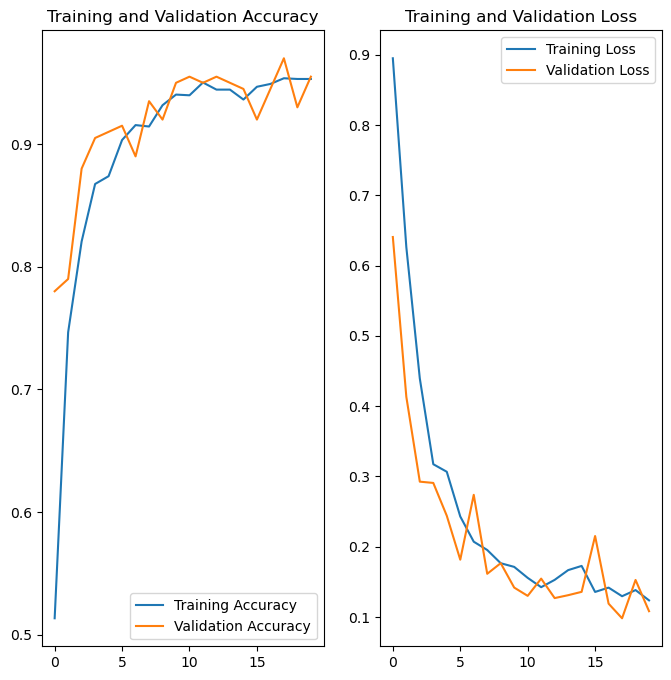

In [20]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

In [22]:
true_labels = []
pred_labels = []
for images_batch, labels_batch in test_ds.take(14):
    batch_prediction=model.predict(images_batch).argmax(axis=1)
    for i in labels_batch:
        true_labels.append(i)
    for i in batch_prediction:
        pred_labels.append(i)

1/1 [==============================] - 0s 139ms/step


In [23]:
def predict(model, img):
    img_array=tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array=tf.expand_dims(img_array,0)
    predictions=model.predict(img_array)
    predicted_class=class_names[np.argmax(predictions[0])]
    confidence=round(100*(np.max(predictions[0])),2)
    return predicted_class, confidence

1/1 [==============================] - 0s 45ms/step


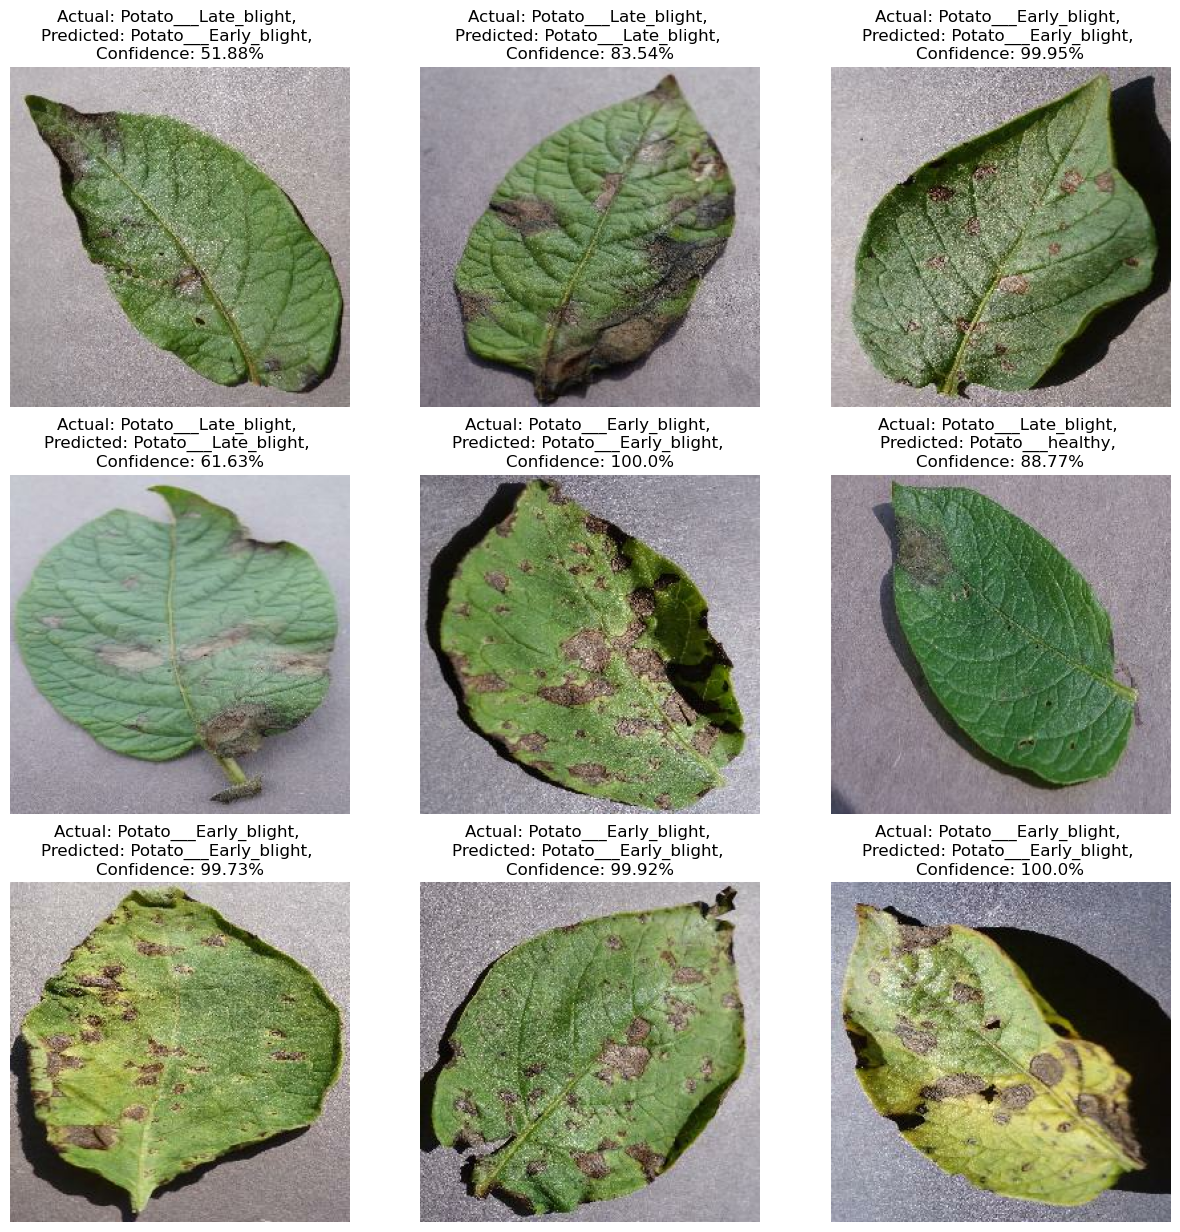

In [24]:
plt.figure(figsize=(15,15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax=plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        predicted_class, confidence=predict(model,images[i].numpy())
        actual_class=class_names[labels[i]]
        plt.title(f"Actual: {actual_class}, \nPredicted: {predicted_class}, \nConfidence: {confidence}%")
        plt.axis("off")

In [25]:
print ("Classification Report: \n", classification_report(true_labels, pred_labels))

Classification Report: 
               precision    recall  f1-score   support

           0       0.95      0.99      0.97       115
           1       0.98      0.91      0.94       102
           2       0.67      0.86      0.75         7

    accuracy                           0.95       224
   macro avg       0.87      0.92      0.89       224
weighted avg       0.95      0.95      0.95       224



In [26]:
cm=tf.math.confusion_matrix(true_labels, pred_labels)
cm

<tf.Tensor: shape=(3, 3), dtype=int32, numpy=
array([[114,   1,   0],
       [  6,  93,   3],
       [  0,   1,   6]])>

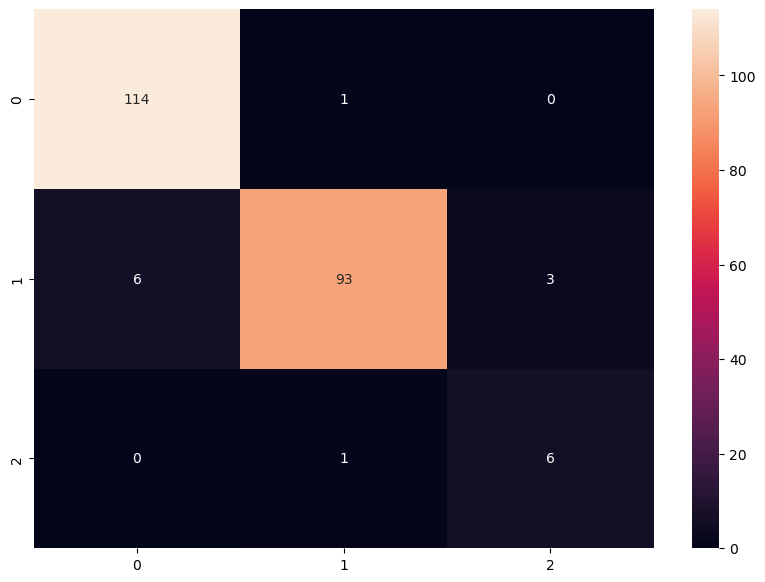

In [27]:
plt.figure(figsize=(10,7))
sn.heatmap(cm,annot=True,fmt='d')
plt.xlabel=('Predicted')
plt.ylabel=('Truth')

In [28]:
filename = "Model1-BatchSize16.joblib"
joblib.dump(model, filename)

['Model1-BatchSize16.joblib']